# Writing Cloud Optimized Geotiffs (COGs) with Python

## Environment

The packages needed for this notebook can be installed with `conda` or `mamba`. Using the [`environment.yml` from this folder](./environment.yml) run:

```bash
conda env create -f environment.yml
```

or

```bash
mamba env create -f environment.yml
```

Finally, you may activate and select the kernel in the notebook (running in Jupyter)

```bash
conda activate coguide-cog
```

The notebook has been tested to work with the listed Conda environment.

## Setup

This tutorial will explore accessing a regular GeoTIFF (Non-COG), converting it to Cloud-Optimized GeoTIFF (COG) format with Python and validate the data inside the COG and Non-COG.

## About the Dataset

We will be using the [NASADEM Merged DEM Global 1 arc second V001](https://doi.org/10.5067/MEASURES/NASADEM/NASADEM_HGT.001) from the NASA EarthData. To access NASA EarthData into Jupyter Notebook, you can create an account by visiting [NASA's Earthdata Login page](https://urs.earthdata.nasa.gov/users/new). This will enable you to register for an account and retrieve the datasets used in the notebook.

We will use [earthaccess](https://github.com/nsidc/earthaccess) library to set up credentials to fetch data from NASA's EarthData catalog.

In [29]:
import earthaccess
import rasterio
from rasterio.plot import show
from rasterio.io import MemoryFile
from rasterio.shutil import copy
from rio_cogeo import cog_validate, cog_info
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
import os
import numpy

In [2]:
earthaccess.login()

## Creating a Data Directory for this Tutorial

We are creating a data directory for downloading all the required files locally. 

In [3]:
# set data directory path
data_dir = './data'

# check if directory exists -> if directory doesn't exist, directory is created
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

## Downloading the Dataset from EarthData

We are using `search_data` method from the `earthaccess` module for searching the Granules from the selected collection.

In [4]:
# Search Granules
short_name = 'NASADEM_HGT'
version = '001'

dem_item_results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    count=2
)

Granules found: 14520


In [10]:
# Download Data - Selecting the 2nd file from the `dem_item_results` list
nasa_dem_files = earthaccess.download(dem_item_results[1], data_dir)
nasa_dem_filename = f"{nasa_dem_files[0]}"
print(nasa_dem_filename)

 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1766.77it/s]


File NASADEM_HGT_n57e105.zip already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 13934.56it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 28532.68it/s]

data/NASADEM_HGT_n57e105.zip


## Loading the Downloaded file 

We will use `rasterio` to read the downloaded zip file. The `rasterio.open()` uses GDAL’s [virtual filesystem interface](https://gdal.org/user/virtual_file_systems.html) to access local ZIP datasets. This requires prepending `zip` to the local zip file URI and adding the internal location to the dataset file after the `!` character. For more details, refer [here](https://rasterio.readthedocs.io/en/latest/topics/vsi.html).

Additionally, we will be using `rasterio.open()` in a `rasterio.Env()` so as to define the `GDAL_DRIVER_NAME` for opening the `SRTM` files. GDAL has an in-built SRTMHGT [driver](https://gdal.org/drivers/raster/srtmhgt.html) for opening the SRTM HGT file formats. The SRTM zip files consists of HGT files named like `nXXeYYY.hgt`. For eg, the downloaded file `NASADEM_HGT_n57e105.zip` consists of `n57e105.hgt`. The readers are recommended to follow the [SRTM documentation](http://dds.cr.usgs.gov/srtm/version2_1/Documentation) for more details. 

In [19]:
#Getting the current working directory
base_dir = os.getcwd()

#Extracting nXXXeXXX information from the filename
zip_filename = nasa_dem_filename.split('/')[-1].split('_')[-1] # n57e105.hgt
hgt_filename = zip_filename.replace('zip', 'hgt')

# "zip:///Users/rajatshinde/impact/cloud-optimized-geospatial-formats-guide/cloud-optimized-geotiffs/data/NASADEM_HGT_n57e105.zip!n57e105.hgt"
hgt_file_path = "zip:///" + os.path.join(base_dir, nasa_dem_filename) + f"!{hgt_filename}"

zip:////Users/rajatshinde/impact/cloud-optimized-geospatial-formats-guide/cloud-optimized-geotiffs/data/NASADEM_HGT_n57e105.zip!n57e105.hgt


In [20]:
#Reading the HGT file using `SRTMHGT` GDAL driver

with rasterio.Env(GDAL_DRIVER_NAME='SRTMHGT'):
    with rasterio.open(hgt_file_path) as src:
        arr = src.read()
        kwargs = src.meta

Let's explore the dataset by printing the metadata and plotting it. 

In [21]:
print("Metadata", kwargs)

Metadata {'driver': 'SRTMHGT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, 104.99986111111112,
       0.0, -0.0002777777777777778, 58.00013888888889)}


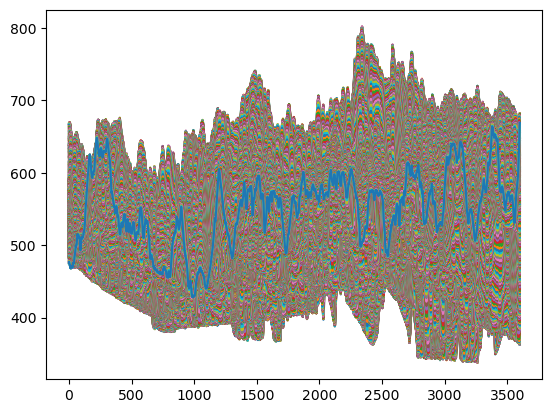

In [22]:
import matplotlib.pyplot as plt
plt.plot(arr[0])
plt.show()

## Converting to Cloud-Optimized GeoTIFF (COG)

There are multiple ways to write a COG in Python. We are presenting the recommended approach based on `rio_cogeo.cog_translate()` method using the Memoryfile. This approach is found to be efficient for writing big GeoTIFF files in cloud-optimized format along with copying the overviews and input dataset metadata. 

In [26]:
# Defining the output COG filename
# /Users/rajatshinde/impact/cloud-optimized-geospatial-formats-guide/cloud-optimized-geotiffs/data/NASADEM_HGT_n57e105_COG.tif
cog_filename = os.path.join(base_dir, nasa_dem_filename.replace(".zip", "_COG.tif"))

# Setting to default GTiff driver as we will be using `rio-cogeo.cog_translate()`
kwargs.update(driver="GTiff", predictor=2)

with MemoryFile() as memfile:
    with memfile.open(**kwargs) as mem:
        # Populate the input file with numpy array
        print(mem)
        mem.write(arr)
        dst_profile = cog_profiles.get("deflate")
        cog_translate(
            mem,
            cog_filename,
            dst_profile,
            in_memory=False
        )

/var/folders/h7/l61pvww15kz03l7fxjhts_wr0000gp/T/ipykernel_72644/3712436250.py:14: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  cog_translate(
Reading input: <open DatasetWriter name='/vsimem/0d437145-5fbb-44f4-aa30-a3706e592a71/0d437145-5fbb-44f4-aa30-a3706e592a71.tif' mode='w+'>

Adding overviews...


<open DatasetWriter name='/vsimem/0d437145-5fbb-44f4-aa30-a3706e592a71/0d437145-5fbb-44f4-aa30-a3706e592a71.tif' mode='w+'>


Updating dataset tags...
Writing output to: /Users/rajatshinde/impact/cloud-optimized-geospatial-formats-guide/cloud-optimized-geotiffs/data/NASADEM_HGT_n57e105_COG.tif


## Validating the Generated COG 

We can validate the generated COG using the `rio_cogeo.cog_validate()`. The `cog_validate` method returns following outputs:
* `is_valid`: `bool` \
    True if 'src_path' is a valid COG.
* errors: `list` \
    List of validation errors if `is_valid` returns False.
* warnings: `list` \
    List of validation warnings if `is_valid` returns False.

In [50]:
cog_validate(cog_filename)

(True, [], [])

As we can see, the generated COG is a valid COG.

## Run validation tests

The `cog_validate` method runs on the COG file. Let's try to run a validation test on the arrays representing the COG and Non-COG file using Numpy's `assert_array_equal` [method](https://numpy.org/doc/stable/reference/generated/numpy.testing.assert_array_equal.html).

In [32]:
# Reading the generated COG file
with rasterio.open(cog_filename) as src:
   arr_cog = src.read()

In [30]:
# Would not output anything if both the COG and non-COG files have equal values
numpy.testing.assert_array_equal(arr, arr_cog)